## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make the notebook executable on google colab
if 'google.colab' in str(get_ipython()):
    # install package
    try:
      import gsemantique
    except ImportError:
      !git clone https://github.com/fkroeber/gsemantique.git
      !cd gsemantique && pip install .
      # re-install latest version of semantique with semantic temporal filter evaluation 
      !pip install --upgrade --no-deps --force-reinstall git+https://github.com/fkroeber/semantique.git@latest 
    # change working directory
    demo_dir = "gsemantique/demo"
    import os
    if not os.getcwd().endswith(demo_dir):
      os.chdir(demo_dir)
else:
    # get the logger to investigate the logs 
    import logging
    import sys
    logger = logging.getLogger("gsemantique.data.search")
    logger.setLevel(logging.INFO)
    stream_handler = logging.StreamHandler()
    logger.addHandler(stream_handler)

In [3]:
# load packages
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray as rxr
import semantique as sq
import stackstac
import warnings

from gsemantique.data.datasets import *
from gsemantique.data.search import Finder
from gsemantique.data.download import Downloader
from gsemantique.process.scaling import TileHandler
from gsemantique.process.utils import update_na, change_dtype
from shapely.geometry import box

In [4]:
# get gsemantiques layout file
import gsemantique
package_dir = os.path.split(gsemantique.__file__)[0]
layout_path = os.path.join(package_dir, "data", "layout.json")

# load data catalog
ds_catalog = DatasetCatalog()
ds_catalog.load()

## Intro

This notebook aims to demonstrate that gsemantique allows:
* to perform multimodal queries, i.e. leverage & combine multiple datasets in one recipe
* to use pre-existing semantic concepts but also to manually define entities in a flexible manner
* to run a set of different recipes based on several entity definitions to derive at a set of model predictions
* to evaluate temporal filter semantically, i.e. to automatically subset the loaded data to the minimum required extent 

The application case is the analysis of forest disturbances. We will aggregate some observations over time for the areas defined as forest. Areas representing forest will be classified in an initial year (2020) and then be monitored over the next couple of years. Forest disturbance modelling is chosen as an example because it's an application field where it is apparent that any well-defined model...  

a) probably needs to consider multiple different datasets to have sufficient information for modelling this complex phenomenon  
b) needs the have an understanding of entities (namely forests)  
c) will have some inherent uncertainty due to...  
* an imprecise or debatable definition of the term "disturbance"
* the restricted capabilities to capture different kinds of disturbances with remote sensing imagery  

...where the former points (a & b) enable to showcase gsemantique's potential for multimodal, semantic queries, and the last point (c) gives rise to the importance of designing a model suite (instead of a single model), revealing some uncertainty in entity and recipe definitions.

<i>Note: Since the subsequent cells will load multimodal data for multiple years for multiple models (total of several Gb), the calculations take some time. Expect something like 45 minutes for the whole notebook when running it on Google Colab. Thus, running it locally is commended.</i>

## Creating a model suite

The definition of the entity "forest" itself can be based on different datasets. We will compare two ways of defining forests:
* drawing them from an existing classification (ESA Worldcover) 
* creating them manually in a ruleset-based fashion (leveraging S1, S2 & DEM data)

Note that for the latter, we combine several conditions for an observation to be classified as forest. All these conditions reflect knowledge about the phenomenon such as that forests have a high NDVI during summer months and only appear in low to mid-altitude regions (below the natural timberline). In terms of radar backscatter properties it is reasonable to assume that forests exhibit low coherence values and low backscatter intensities as they are essentially vegetation characterized primarily by volume scattering that changes over time. Note that the specific thresholds used here to define forests in a custom way are just some rough estimates of reasonable figures to demonstrate the principle of defining your own entities based on a variety of datasets for which gsemantique offers predefined access. 

In [5]:
# necessary preprocessing for SAR data
def rescale_sar(obj, track_types=True, **kwargs):
    # self-contained imports
    import numpy as np
    import semantique as sq
    # rescale SAR data 
    newobj = obj.copy(deep=True)
    newobj.values = 20*np.log10(obj.values) - 83
    # track value types
    if track_types:
        newobj.sq.value_type = sq.processor.types.get_value_type(newobj)
    return newobj
    
# forest definitions
forest_defs = {
    "esa_worldcover": {
        "appearance": (
        sq.layer("Planet", "classification", "esa_lc")
        .evaluate("equal", 10)
        .filter_time("year", "equal", 2020) 
        .reduce("any", "time")
        )
    },
    "own_definition": {
        "appearance": (
            sq.layer("Planet", "reflectance", "s2_band08")
            .evaluate("normalized_difference", sq.layer("Planet", "reflectance", "s2_band04"))
            .filter_time("year", "equal", 2020)
            .filter_time("month", "equal", 6)
            .reduce("mean", "time")
            .evaluate("greater", 0.3)
        ),
        "coherence": (
            sq.layer("ASF", "coherence", "s1_coh12_vv")
            .filter_time("year", "equal", 2020)   
            .evaluate("divide", 100)
            .reduce("max", "time")
            .evaluate("less", 0.25)
        ),
        "reflectance": (
            sq.layer("ASF", "reflectance", "s1_amp_vh")
            .filter_time("year", "equal", 2020)   
            .reduce("min", "time")
            .apply_custom("rescale_sar")
            .evaluate("in", sq.interval(-16.5, -10))
        ),
        "elevation": (
            sq.layer("Planet", "topography", "dem")
            .reduce("mean", "time")
            .evaluate("less", 2250)
        )
    },
}

In terms of recipes to model forest disturbances we will build on the idea that disturbances are indicated by a loss of temporary or permanent loss of vegetation. Thus, we define a vegetation entity whose occurrence can be monitored over time. If the share of vegetation counts relative to all cloudfree observations per year decreases significantly this will be regarded as a disturbance. Two different models will be defined based upon different thresholds for detecting when a decrease in vegetation becomes significant. The results will be summarized in a measure of disturbance magnitude and persistence, where the definition of the former also varies between models. Note that these models again are only simple heuristics-based approaches to showcase the possibilities. There are numerous things that could be done to increase the models accuracy and reliability if that's what you are aiming for as a user. 

In [6]:
# define relevant entities
mapping = sq.mapping.Semantique()
mapping["entity"] = {}
mapping["entity"]["forest"] = None # will be plugged in later
mapping["entity"]["vegetation"] = {"color": sq.layer("Planet", "classification", "scl").evaluate("equal", 4)}
mapping["entity"]["valid_obs"] = {"color": sq.layer("Planet", "classification", "scl").evaluate("in", [4,5,6])}
mapping["entity"]["all"] = {"color": sq.layer("Planet", "classification", "scl").evaluate("not_equal", 0)}

# define 2 recipes
recipes = {"robust": None, "sensitive": None}

# define robust recipe
recipe = sq.QueryRecipe()
recipe["forest"] = sq.entity("forest")
recipe["stats"] = (sq.entity("all")
    .filter(sq.entity("valid_obs"))
    .groupby_time("year")
    .reduce("count", "time")
    .concatenate("year")
    .apply_custom("change_dtype", dtype="int16")
)
recipe["mask"] = (sq.result("stats")
    .filter(sq.result("forest"))
    .reduce("min", "year")
    .evaluate("greater", 5)
)
recipe["status_orginal"] = (sq.entity("vegetation")
    .filter(sq.result("mask"))
    .filter(sq.entity("valid_obs"))
    .filter_time("year", "equal", 2020)   
    .reduce("percentage", "time")
    .apply_custom("change_dtype", dtype="int16")
)
recipe["status_post"] = (sq.entity("vegetation")
    .filter(sq.result("mask"))
    .filter(sq.entity("valid_obs"))
    .groupby_time("year")
    .reduce("percentage", "time")
    .evaluate("subtract", sq.result("status_orginal"))
    .concatenate("year")
    .filter(sq.self().extract("year").evaluate("equal", 2020).evaluate("not"))
    .trim()
    .evaluate("absolute")
    .apply_custom("update_na")
    .apply_custom("change_dtype", dtype="float32")
)
recipe["change"] = (sq.result("status_post")
    .filter(sq.self().evaluate("greater", 20))
)
recipe["magnitude"] = sq.result("change").reduce("max", "year")
recipe["persistance"] = sq.result("change").evaluate("greater", 0).reduce("count", "year")
recipes["robust"] = recipe

# define sensitive recipe
recipe = sq.QueryRecipe()
recipe["forest"] = sq.entity("forest")
recipe["stats"] = (sq.entity("all")
    .filter(sq.entity("valid_obs"))
    .groupby_time("year")
    .reduce("count", "time")
    .concatenate("year")
    .apply_custom("change_dtype", dtype="int16")
)
recipe["mask"] = (sq.result("stats")
    .filter(sq.result("forest"))
    .reduce("min", "year")
    .evaluate("greater", 5)
)
recipe["status_orginal"] = (sq.entity("vegetation")
    .filter(sq.result("mask"))
    .filter(sq.entity("valid_obs"))
    .filter_time("year", "equal", 2020)   
    .reduce("percentage", "time")
    .apply_custom("change_dtype", dtype="int16")
)
recipe["status_post"] = (sq.entity("vegetation")
    .filter(sq.result("mask"))
    .filter(sq.entity("valid_obs"))
    .groupby_time("year")
    .reduce("percentage", "time")
    .evaluate("subtract", sq.result("status_orginal"))
    .concatenate("year")
    .filter(sq.self().extract("year").evaluate("equal", 2020).evaluate("not"))
    .trim()
    .evaluate("absolute")
    .apply_custom("update_na")
    .apply_custom("change_dtype", dtype="float32")
)
recipe["change"] = (sq.result("status_post")
    .filter(sq.self().evaluate("greater", 10))
)
recipe["magnitude"] = sq.result("change").reduce("mean", "year")
recipe["persistance"] = sq.result("change").evaluate("greater", 0).reduce("count", "year")
recipes["sensitive"] = recipe

## Executing the models

To evaluate the models, we will need to define the spatio-temporal extent of the study area. We will use an area in Austria close to Wallersee where its known that some forest changes have occurred. 

In [7]:
# load AoI
_aoi = gpd.read_file("files/sbg_forest.geojson").to_crs(4326)
xmin, ymin, xmax, ymax = _aoi.total_bounds
aoi_bbox = box(xmin, ymin, xmax, ymax)

# define extent
res = 20
epsg = 3035
t_start = "2020-01-01"
t_end = "2024-01-01"
time = sq.TemporalExtent(pd.Timestamp(t_start), pd.Timestamp(t_end))
space = sq.SpatialExtent(_aoi)

In [8]:
# iterate over entity & recipe definitions
for f_def,f_v in forest_defs.items():
    for r_def,r_v in recipes.items():

        # plug in entity definition
        mapping["entity"]["forest"] = f_v

        # create Finder instance & search for relevant data
        fdr = Finder(ds_catalog, t_start, t_end, aoi_bbox)
        fdr.search_auto(
            recipe,
            mapping,
            custom_verbs={
                "update_na": update_na, 
                "change_dtype": change_dtype, 
                "rescale_sar": rescale_sar,
            }
        )

        # init datacube
        with open(layout_path, "r") as file:
            dc = sq.datacube.STACCube(
                json.load(file), 
                src = fdr.item_coll,
                group_by_solar_day=True,
                dask_params=None
            )


        # create TileHandler instance
        out_dir = f"results/{f_def}_{r_def}"
        context = dict(
            recipe=r_v,
            datacube=dc,
            mapping=mapping,
            space=space,
            time=time,
            spatial_resolution=[-res, res],
            crs=epsg,
            chunksize_t='1W',
            chunksize_s=1024,
            merge_mode="merged",
            out_dir=out_dir,
            reauth=True,
            custom_verbs={
                "update_na": update_na, 
                "change_dtype": change_dtype, 
                "rescale_sar": rescale_sar,
            },
            track_types=True
        )

        # execute processing
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            th = TileHandler(**context)
            th.execute()

The recipe references the following data layers:
('Planet', 'classification', 'esa_lc')
('Planet', 'classification', 'scl')
Initialise search for ('Planet', 'classification', 'esa_lc')
Search started
Search finished
Search postprocessed
Found 2 datasets
Initialise search for ('Planet', 'classification', 'scl')
Search started
Search finished
Search postprocessed
Found 564 datasets
creating spatial grid: 100%|██████████| 2/2 [00:00<00:00, 62.74it/s]


The following numbers are rough estimations depending on the chosen strategy for merging the individual tile results. If merge='merged' is choosen the total size indicates a lower bound for how much RAM is required since the individual tile results will be stored in RAM before merging.

------------------------------------------
General layer info
------------------------------------------
layer          : dtype     crs   res      
------------------------------------------
forest         : float64   3035  [-20, 20]
stats          : int16     3035  [-20, 20]
mask           : float64   3035  [-20, 20]
status_orginal : int16     3035  [-20, 20]
status_post    : float32   3035  [-20, 20]
change         : float32   3035  [-20, 20]
magnitude      : float32   3035  [-20, 20]
persistance    : float64   3035  [-20, 20]
------------------------------------------

-----------------------------------------------------
Scenario: 'merge' = None
-----------------------------------------------------


executing recipe in tiled manner: 100%|██████████| 2/2 [01:08<00:00, 34.40s/it]
The recipe references the following data layers:
('Planet', 'classification', 'esa_lc')
('Planet', 'classification', 'scl')
Initialise search for ('Planet', 'classification', 'esa_lc')
Search started
Search finished
Search postprocessed
Found 2 datasets
Initialise search for ('Planet', 'classification', 'scl')
Search started
Search finished
Search postprocessed
Found 564 datasets
creating spatial grid: 100%|██████████| 2/2 [00:00<00:00, 83.46it/s]


The following numbers are rough estimations depending on the chosen strategy for merging the individual tile results. If merge='merged' is choosen the total size indicates a lower bound for how much RAM is required since the individual tile results will be stored in RAM before merging.

------------------------------------------
General layer info
------------------------------------------
layer          : dtype     crs   res      
------------------------------------------
forest         : float64   3035  [-20, 20]
stats          : int16     3035  [-20, 20]
mask           : float64   3035  [-20, 20]
status_orginal : int16     3035  [-20, 20]
status_post    : float32   3035  [-20, 20]
change         : float32   3035  [-20, 20]
magnitude      : float32   3035  [-20, 20]
persistance    : float64   3035  [-20, 20]
------------------------------------------

-----------------------------------------------------
Scenario: 'merge' = None
-----------------------------------------------------


executing recipe in tiled manner: 100%|██████████| 2/2 [01:09<00:00, 34.86s/it]
The recipe references the following data layers:
('Planet', 'reflectance', 's2_band04')
('ASF', 'coherence', 's1_coh12_vv')
('Planet', 'classification', 'scl')
('Planet', 'reflectance', 's2_band08')
('ASF', 'reflectance', 's1_amp_vh')
('Planet', 'topography', 'dem')
Initialise search for ('Planet', 'reflectance', 's2_band04')
Search started
Search finished
Search postprocessed
Found 564 datasets
Initialise search for ('ASF', 'coherence', 's1_coh12_vv')
Search started
Search finished
Search postprocessed
Found 4 datasets
Initialise search for ('Planet', 'classification', 'scl')
Search started
Search finished
Search postprocessed
Found 564 datasets
Initialise search for ('Planet', 'reflectance', 's2_band08')
Search started
Search finished
Search postprocessed
Found 564 datasets
Initialise search for ('ASF', 'reflectance', 's1_amp_vh')
Search started
Search finished
Search postprocessed
Found 4 datasets
Initia

The following numbers are rough estimations depending on the chosen strategy for merging the individual tile results. If merge='merged' is choosen the total size indicates a lower bound for how much RAM is required since the individual tile results will be stored in RAM before merging.

------------------------------------------
General layer info
------------------------------------------
layer          : dtype     crs   res      
------------------------------------------
forest         : float64   3035  [-20, 20]
stats          : int16     3035  [-20, 20]
mask           : float64   3035  [-20, 20]
status_orginal : int16     3035  [-20, 20]
status_post    : float32   3035  [-20, 20]
change         : float32   3035  [-20, 20]
magnitude      : float32   3035  [-20, 20]
persistance    : float64   3035  [-20, 20]
------------------------------------------

-----------------------------------------------------
Scenario: 'merge' = None
-----------------------------------------------------


executing recipe in tiled manner: 100%|██████████| 2/2 [01:46<00:00, 53.01s/it]
The recipe references the following data layers:
('Planet', 'reflectance', 's2_band04')
('ASF', 'coherence', 's1_coh12_vv')
('Planet', 'classification', 'scl')
('Planet', 'reflectance', 's2_band08')
('ASF', 'reflectance', 's1_amp_vh')
('Planet', 'topography', 'dem')
Initialise search for ('Planet', 'reflectance', 's2_band04')
Search started
Search finished
Search postprocessed
Found 564 datasets
Initialise search for ('ASF', 'coherence', 's1_coh12_vv')
Search started
Search finished
Search postprocessed
Found 4 datasets
Initialise search for ('Planet', 'classification', 'scl')
Search started
Search finished
Search postprocessed
Found 564 datasets
Initialise search for ('Planet', 'reflectance', 's2_band08')
Search started
Search finished
Search postprocessed
Found 564 datasets
Initialise search for ('ASF', 'reflectance', 's1_amp_vh')
Search started
Search finished
Search postprocessed
Found 4 datasets
Initia

The following numbers are rough estimations depending on the chosen strategy for merging the individual tile results. If merge='merged' is choosen the total size indicates a lower bound for how much RAM is required since the individual tile results will be stored in RAM before merging.

------------------------------------------
General layer info
------------------------------------------
layer          : dtype     crs   res      
------------------------------------------
forest         : float64   3035  [-20, 20]
stats          : int16     3035  [-20, 20]
mask           : float64   3035  [-20, 20]
status_orginal : int16     3035  [-20, 20]
status_post    : float32   3035  [-20, 20]
change         : float32   3035  [-20, 20]
magnitude      : float32   3035  [-20, 20]
persistance    : float64   3035  [-20, 20]
------------------------------------------

-----------------------------------------------------
Scenario: 'merge' = None
-----------------------------------------------------


executing recipe in tiled manner: 100%|██████████| 2/2 [03:14<00:00, 97.30s/it] 


## Visualising the results

To visualize the results, we will first search for some nice cloudfree S2 images for the given time of interest to have them as a reference for visual inspection of the results.

The recipe references the following data layers:
('Planet', 'reflectance', 's2_band02')
('Planet', 'reflectance', 's2_band03')
('Planet', 'reflectance', 's2_band04')
('Planet', 'classification', 'scl')
Initialise search for ('Planet', 'reflectance', 's2_band02')
Search started
Search finished
Search postprocessed
Found 480 datasets
Initialise search for ('Planet', 'reflectance', 's2_band03')
Search started
Search finished
Search postprocessed
Found 480 datasets
Initialise search for ('Planet', 'reflectance', 's2_band04')
Search started
Search finished
Search postprocessed
Found 480 datasets
Initialise search for ('Planet', 'classification', 'scl')
Search started
Search finished
Search postprocessed
Found 480 datasets
c:\Users\felix\.virtualenvs\gsemantique\lib\site-packages\stackstac\prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-

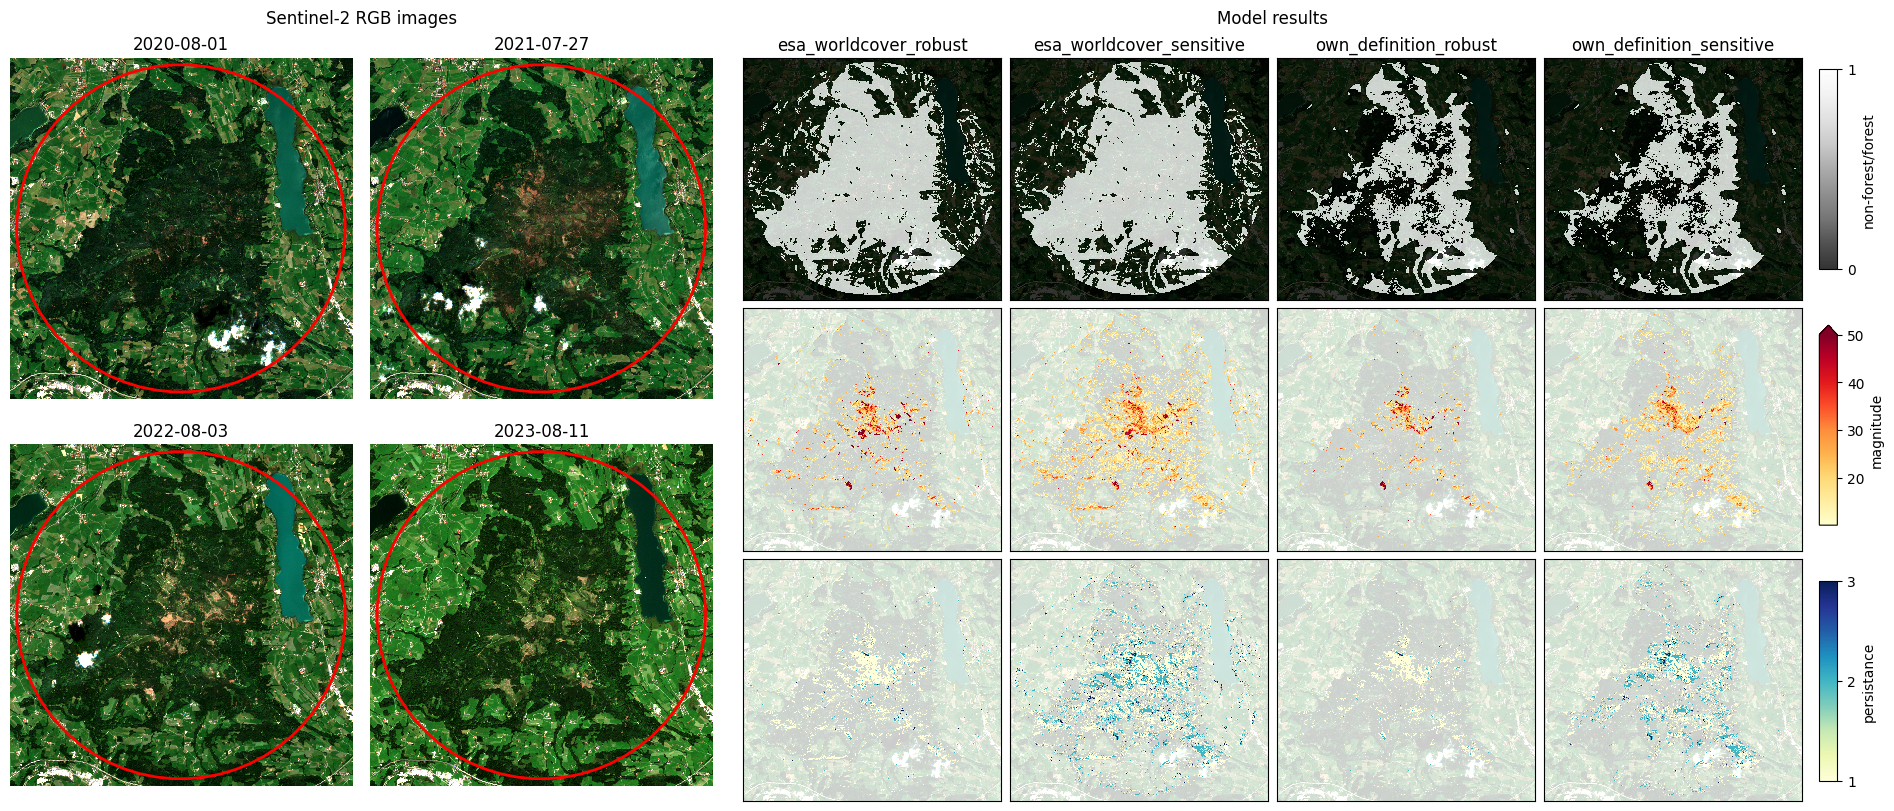

In [9]:
t_start = "2020-05-01"
t_end = "2023-10-01"

# define mapping with bands of interest
mapping = sq.mapping.Semantique()
mapping["entity"] = {}
mapping["entity"]["foo"] = {
    "prop1": sq.layer("Planet", "classification", "scl"),
    "prop2": sq.layer("Planet", "reflectance", "s2_band02"),
    "prop3": sq.layer("Planet", "reflectance", "s2_band03"),
    "prop4": sq.layer("Planet", "reflectance", "s2_band04"),
}

# define recipe
recipe = sq.QueryRecipe()
recipe["foo"] = sq.entity("foo")

# use gsemantique to search for relevant data
fdr = Finder(ds_catalog, t_start, t_end, aoi_bbox)
fdr.search_auto(
    recipe, 
    mapping
)

# stack results to single array
arr = stackstac.stack(
    fdr.item_coll,
    epsg=3035,
    bounds_latlon=aoi_bbox.bounds,
    resolution=(10,10),
    rescale=False,
    xy_coords="center",
    snap_bounds=False,
)

# get cloud free images
cloudfree_share = arr.sel(band="SCL").isin([4, 5, 6, 7]).sum(dim=["y", "x"])/arr.sel(band="SCL").count(dim=["y", "x"])
cloudfree_imgs = arr.sel(band="SCL")[cloudfree_share.values > 0.99]
cloudfree_imgs['time'] = pd.to_datetime(cloudfree_imgs['time'].values)

# group by year and find the closest time step to the target date
closest_times = []
for year, group in cloudfree_imgs.groupby('time.year'):
    target_date = pd.Timestamp(year=year, month=7, day=30)
    differences = np.abs(group['time'].values - target_date.to_datetime64())
    closest_time = group['time'].values[differences.argmin()]
    closest_times.append(closest_time)

# filter the original DataArray to include only the closest time steps
final_filtered_scenes = cloudfree_imgs.sel(time=closest_times)
final_filtered_scenes

# plot results
fig = plt.figure(layout='constrained', figsize=(18, 8))
subfigs = fig.subfigures(1, 2, wspace=0.025, width_ratios=[0.4, 0.6])

axsLeft = subfigs[0].subplots(2, 2)
axsRight = subfigs[1].subplots(3, 4)

subfigs[0].suptitle('Sentinel-2 RGB images')
rgb_arr = arr[arr.id.isin(final_filtered_scenes.id)].sel(band=["B04", "B03", "B02"])
for i, time in enumerate(rgb_arr.time):
    t_arr = rgb_arr.sel(time=time)
    vmin, vmax = np.nanquantile(np.array(t_arr), [0.01, 0.99])
    t_arr.plot.imshow(ax=axsLeft.flat[i], vmin=vmin, vmax=vmax)
    _aoi.to_crs(t_arr.rio.crs).plot(ax=axsLeft.flat[i], edgecolor='red', color='none', linewidth=2)
    axsLeft.flat[i].set_title(str(time.values).split("T")[0])
    axsLeft.flat[i].axis('off')

subfigs[1].suptitle('Model results')
c = 0

for f_def,f_v in forest_defs.items():
    for r_def,r_v in recipes.items():
        
        # plot forest extent
        path_forest = f"results/{f_def}_{r_def}/forest.tif"
        status = rxr.open_rasterio(path_forest)
        status = status.rio.reproject_match(rgb_arr, nodata=0)
        rgb_arr.isel(time=0).plot.imshow(ax=axsRight[0, c], robust=True)
        img1 = status[0].plot.imshow(cmap="Greys_r", ax=axsRight[0, c], add_colorbar=False, alpha=0.8)	
        axsRight[0, c].set_title(None)

        # plot magnitude
        path_mag = f"results/{f_def}_{r_def}/magnitude.tif"
        status = rxr.open_rasterio(path_mag)
        status = status.rio.reproject_match(rgb_arr, nodata=0)
        rgb_arr.isel(time=0).plot.imshow(ax=axsRight[1, c], robust=True, alpha=0.2)
        img2 = status[0].plot.imshow(cmap="YlOrRd", vmax=50,  ax=axsRight[1, c], add_colorbar=False, extend='both')
        axsRight[1, c].set_title(None)

        # plot persistance
        path_pers = f"results/{f_def}_{r_def}/persistance.tif"
        status = rxr.open_rasterio(path_pers)
        status = status.rio.reproject_match(rgb_arr, nodata=0)
        rgb_arr.isel(time=0).plot.imshow(ax=axsRight[2, c], robust=True, alpha=0.2)
        img3 = status[0].plot.imshow(cmap="YlGnBu", vmin=1, vmax=3, ax=axsRight[2, c], add_colorbar=False)
        axsRight[2, c].set_title(None)
        axsRight[0, c].set_title(f"{f_def}_{r_def}")
        c += 1

for ax in axsRight.flat:
    ax.tick_params(right=False,top=False,left=False, bottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

cbar_ax1 = fig.add_axes([1.0075, 0.67, 0.01, 0.25]) 
cbar1 = fig.colorbar(img1, cax=cbar_ax1)
cbar1.set_ticks([0, 1])
cbar1.set_label('non-forest/forest')

cbar_ax2 = fig.add_axes([1.0075, 0.35, 0.01, 0.25]) 
cbar2 = fig.colorbar(img2, cax=cbar_ax2, extend='max')
cbar2.set_label('magnitude')

cbar_ax3 = fig.add_axes([1.0075, 0.03, 0.01, 0.25]) 
cbar3 = fig.colorbar(img3, cax=cbar_ax3)
cbar3.set_ticks([1,2,3])
cbar3.set_label('persistance')

As evident from the figure above, ESA's worldcover definition and our custom definition yield similar yet slightly different results for the delineation of forest areas. In combination with the different sensitivities of the disturbance models we obtain four different estimates of disturbed areas. As a user or domain expert, you can now decide which model matches the expectations best. Or you could proceed with some ensembling to represent areas where all models agree and areas where models diverge (indicative of high predictive uncertainty).     